In [1]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.init as init


from torch.utils.data import Dataset, DataLoader
from scipy import signal
torch.set_default_tensor_type(torch.FloatTensor)


In [2]:
'''
Gearating a desired signal for network to mimic
'''

layers=6
x_val=[]
y_val=[]

scale_factor=5/3  #Determines the scaling size
sample_size=[]
for i in range(layers): #Creating Real-Pyramid of Signal
    sample_len=int(256//((scale_factor)**(layers-i-1)))
    sample_size.append(sample_len)
    x=np.linspace(0, 256, sample_len,endpoint=False)
    x_val.append(x)
   # y_val.append(20*(x/10)/((x/10)**2+10)) 
    y_val.append(np.sin(x/20))

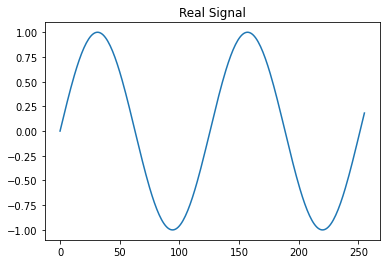

In [3]:
plt.title("Real Signal")
plt.plot(x_val[-1],y_val[-1],'')


In [4]:

'''
Network Block Identical to SinGan Network except the filter size with nn.Con2d to nn.Conv1
'''
class ConvBlock(nn.Sequential):
    def __init__(self, in_channel, out_channel, ker_size, padd, stride):
        super(ConvBlock,self).__init__()
        self.add_module('conv',nn.Conv1d(in_channel ,out_channel,kernel_size=ker_size,stride=stride,padding=padd)),
        self.add_module('LeakyRelu',nn.LeakyReLU(0.2,inplace=False))
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.head=ConvBlock(1,16,ker_size=3,padd=1,stride=1)
        self.body=ConvBlock(16,16,ker_size=3,padd=1,stride=1)
        self.tail=nn.Conv1d(16 ,1,kernel_size=3,stride=1,padding=1)
    def forward(self,x,y):
        x = self.head(x)
        x = self.body(x)
        x = self.tail(x)
    #    ind = int((y.shape[2]-x.shape[2])/2)
    #    y = y[:,:,ind:(y.shape[2]-ind),ind:(y.shape[3]-ind)]
        return x+y

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.head=ConvBlock(1,16,ker_size=3,padd=1,stride=1)
        self.body=ConvBlock(16,16,ker_size=3,padd=1,stride=1)
        self.tail=nn.Conv1d(16 ,1,kernel_size=3,stride=1,padding=1)
        self.tanh=nn.Tanh()
    def forward(self,x):
        x = self.head(x)
        x = self.body(x)
        x = self.tanh(self.tail(x))
        return x    

In [5]:
'''Training Mechanism used in SinGan with Minor modification to 1D'''

def generate_noise(size,num_samp=1,device='cpu',type='uniform', scale=1):
    if type == 'uniform':
        noise = torch.randn(num_samp,size,  device=device)
    return noise.view(num_samp,1,size)
     #   noise = upsampling(noise,size)
        
def calc_gradient_penalty(netD, real_data, fake_data, LAMBDA,device='cpu'):
    alpha = torch.rand(1, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)#.cuda()
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    #LAMBDA = 1
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

import torch.optim as optim

def train_single_scale(netD,netG,reals,Gs,Zs,in_s,NoiseAmp,device='cpu'):
    netD.to(device)
    netG.to(device)
    errD2plot = []
    errG2plot = []
    D_real2plot = []
    D_fake2plot = []
    z_opt2plot = []
    real=torch.from_numpy(reals[len(Gs)]).view(1,1,-1).float()
    seq_length=real.shape[-1]
    optimizerD = optim.Adam(netD.parameters(), lr=0.005, betas=(0.9, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.005, betas=(0.9, 0.999))
    fixed_noise=generate_noise(seq_length,device=device)
    z_opt=torch.full(fixed_noise.shape,0,device=device)
    for epochs in range(200):
        if Gs==[]:
            z_opt=generate_noise(seq_length,device=device)
        noise_ = generate_noise(seq_length,device=device)

    ##Train Discriminator
        for j in range(D_steps):
            netD.zero_grad()
            real=real.to(device)
            output = netD(real)#.to(device)
            errD_real = -output.mean()
            errD_real.backward(retain_graph=True)
            D_x = -errD_real.item()
            if (j==0) & (epochs == 0):
                if (Gs == []):
                    prev = torch.full([1,1,seq_length], 0)
                    in_s = prev
                    z_prev= torch.full([1,1,seq_length], 0)
                    noise_amp=1
                else:
                    prev = draw_concat(Gs,Zs,reals,NoiseAmp,in_s,'rand',device=device)
                    z_prev = draw_concat(Gs,Zs,reals,NoiseAmp,in_s,'rec',device=device)

                    criterion = nn.MSELoss()
                    RMSE = torch.sqrt(criterion(real, z_prev))
                    noise_amp = 0.1*RMSE

            else:
                    prev = draw_concat(Gs,Zs,reals,NoiseAmp,in_s,'rand',device=device)
            if (Gs == []):
                    noise = noise_
            else:
                    noise = noise_amp*noise_+prev
            noise=noise.to(device)
            prev=prev.to(device)
            fake = netG(noise.detach(),prev)
            output = netD(fake.detach())
            errD_fake = output.mean()
            errD_fake.backward(retain_graph=True)
            D_G_z = output.mean().item()

            gradient_penalty = calc_gradient_penalty(netD, real, fake, 0.1,device)
            gradient_penalty.backward()
          #  print(prev)
            errD = errD_real + errD_fake + gradient_penalty
            optimizerD.step()

        errD2plot.append(errD.detach())
        #Train Generator
        for j in range(Gsteps):
                netG.zero_grad()
                output = netD(fake)
                errG = -output.mean()
                errG.backward(retain_graph=True)
                if alpha!=0:
                    loss = nn.MSELoss()
                    z_prev=z_prev.to(device)
                    
                    Z_opt = noise_amp*z_opt+z_prev
                    
                    rec_loss = alpha*loss(netG(Z_opt,z_prev),real)
                    rec_loss.backward(retain_graph=True)
                    rec_loss = rec_loss.detach()
                else:
                    Z_opt = z_opt
                    rec_loss = 0

                optimizerG.step()

        errG2plot.append(errG.detach()+rec_loss)
        D_real2plot.append(D_x)
        D_fake2plot.append(D_G_z)
        z_opt2plot.append(rec_loss)

        if epochs % 50 == 0 :
            print('scale %d:[%d/%d]' % (len(Gs), epochs, 200))
            print("Discriminator Loss: ",abs(errD.item()))
            print("Generator Loss: ",(errG.detach()+rec_loss).item())
    #save_networks(netG,netD,z_opt)        
    return z_opt,in_s,netG ,noise_amp
def init_models(device='cpu'):
    netG=Generator().to(device)
    netD=Discriminator().to(device)
    return netD,netG

def draw_concat(Gs,Zs,reals,NoiseAmp,in_s,mode,device='cpu'):
    G_z = in_s
    
    if len(Gs) > 0:
        
        if mode == 'rand':
            count = 0
            for G,Z_opt,real_curr,real_next,noise_amp in zip(Gs,Zs,reals,reals[1:],NoiseAmp):
                if count == 0:
                    z = generate_noise(Z_opt.shape[2],device=device)
                else:
                    z = generate_noise(Z_opt.shape[2],device=device) 
                G_z=G_z.to(device)
                z_in = noise_amp*z+G_z

                G_z = G(z_in.detach(),G_z).cpu().detach().numpy()
                G_z=signal.resample(G_z.squeeze(0).squeeze(0), len(real_next)).reshape(1,1,-1)
                G_z=torch.from_numpy(G_z).to(device)
                count += 1
        if mode == 'rec':
        
            for G,Z_opt,real_curr,real_next,noise_amp in zip(Gs,Zs,reals,reals[1:],NoiseAmp):
             #   G_z = G_z[:, :, 0:real_curr.shape[2], 0:real_curr.shape[3]]
                G_z=G_z.to(device)
                z_in = noise_amp*Z_opt+G_z
                
          
                G_z = G(z_in,G_z).cpu().detach().numpy()
                G_z=signal.resample(G_z.squeeze(0).squeeze(0), len(real_next)).reshape(1,1,-1)
                G_z=torch.from_numpy(G_z).to(device)

    return G_z

def reset_grads(model,require_grad):
    for p in model.parameters():
        p.requires_grad_(require_grad)
    return model

In [6]:
#Training Process

scale_num=0
max_stop_scale=6
Gs=[]
Zs=[]
NoiseAmp = []
scale=0
in_s = 0
reals=y_val
D_steps=3
Gsteps=3
alpha =10


In [7]:

while scale_num<len(y_val):
    #print(scale_num)
    D_curr,G_curr=init_models()
    
    z_curr,in_s,G_curr,noise_amp = train_single_scale(D_curr,G_curr,reals,Gs,Zs,in_s,NoiseAmp,device='cuda')
    G_curr = reset_grads(G_curr,False)
    G_curr.eval()
    D_curr = reset_grads(D_curr,False)
    D_curr.eval()
    Gs.append(G_curr)
    Zs.append(z_curr)
  #  print(z_curr)
    NoiseAmp.append(noise_amp)
    scale_num+=1
    del D_curr,G_curr



scale 0:[0/200]
Discriminator Loss:  0.06957099586725235
Generator Loss:  4.599336624145508
scale 0:[50/200]
Discriminator Loss:  1.1126904487609863
Generator Loss:  6.039517402648926
scale 0:[100/200]
Discriminator Loss:  1.2816624641418457
Generator Loss:  5.254628658294678
scale 0:[150/200]
Discriminator Loss:  0.6912308931350708
Generator Loss:  4.509236812591553
scale 1:[0/200]
Discriminator Loss:  0.09978926926851273
Generator Loss:  2.9699928760528564
scale 1:[50/200]
Discriminator Loss:  0.045834921300411224
Generator Loss:  0.9492835998535156
scale 1:[100/200]
Discriminator Loss:  0.2646114230155945
Generator Loss:  0.8102966547012329
scale 1:[150/200]
Discriminator Loss:  0.4319520890712738
Generator Loss:  0.6440661549568176
scale 2:[0/200]
Discriminator Loss:  0.04989643767476082
Generator Loss:  0.41201478242874146
scale 2:[50/200]
Discriminator Loss:  0.03052034229040146
Generator Loss:  -0.3025272488594055
scale 2:[100/200]
Discriminator Loss:  0.059440888464450836
Gener

In [8]:
'''Output Generation'''

def SinGAN_generate(Gs,Zs,reals,NoiseAmp,in_s=None,scale_v=1,scale_h=1,n=0,gen_start_scale=0,num_samples=1,device='cpu'):
    #if torch.is_tensor(in_s) == False:
    if in_s is None:
        in_s = torch.full(reals[0].shape, 0)
    images_cur = []
    for G,Z_opt,noise_amp in zip(Gs,Zs,NoiseAmp):

        seq_length = (Z_opt.shape[2])
        G.to(device)
        Z_opt.to(device)
        images_prev = images_cur
        images_cur = []
    
        for i in range(0,num_samples,1):
            z_curr = generate_noise(seq_length,device=device) 
            if images_prev == []:
                I_prev = in_s
                I_prev.detach().numpy()
                I_prev=signal.resample(I_prev.squeeze(0).squeeze(0), z_curr.shape[2]).reshape(1,1,-1)
                I_prev=torch.from_numpy(I_prev)
            else:
                I_prev = images_prev[i]
                

                I_prev=I_prev.cpu().detach().numpy()
                z_curr.cpu().detach()
                I_prev=signal.resample(I_prev.squeeze(0).squeeze(0), z_curr.shape[2]).reshape(1,1,-1)
                I_prev=torch.from_numpy(I_prev)
            if n < gen_start_scale:
                z_curr = Z_opt
            z_curr.to(device)
            I_prev=I_prev.to(device)
            z_in = noise_amp*(z_curr)+I_prev
            
            I_curr = G(z_in.detach(),I_prev)
        images_cur.append(I_curr)
        cur_data=I_curr[0][0].clone()
        cur_data=cur_data.cpu().detach().numpy()
        cur_data=signal.resample(cur_data,256)
        x=np.linspace(0, 256, 256,endpoint=False)

     #   plt.figure()
     #   plt.plot(x,cur_data,'')
    return I_curr.detach().squeeze(0).squeeze(0)

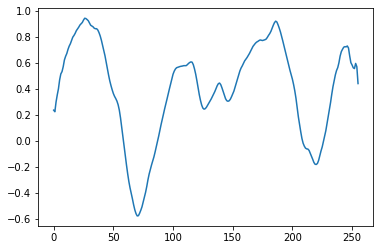

In [11]:
#Preview Sample Output

x=np.linspace(0, 256, 256,endpoint=False)


test_y=SinGAN_generate(Gs,Zs,reals,NoiseAmp,device='cuda')
plt.plot(x,test_y.cpu().detach().numpy(),'')
